In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib
from pathlib import Path

# 現在のノートブックからの相対パスを絶対パスに変換
notebook_dir = Path(os.path.abspath('')).parent
data_path = notebook_dir / 'data' / 'processed' / 'wt262avs.adicht_rec2.parquet'

# データの読み込み
df = pd.read_parquet(data_path)

# データの先頭を表示
print("DataFrameの先頭5行:")
display(df.head())

# データの基本情報を表示
print("\nDataFrameの基本情報:")
display(df.info())

DataFrameの先頭5行:


PFC       PPC         A1         V1  Stimulus  Time_s  PFC_filtered  \
0  63.68750 -48.06250 -76.906250 -55.328125 -0.000312   0.000     -9.687126   
1  42.40625 -50.87500 -80.546875 -57.750000 -0.000312   0.001    -16.177164   
2  31.43750 -70.71875 -99.937500 -82.546875 -0.000312   0.002    -22.393838   
3  30.37500 -44.06250 -70.140625 -49.937500 -0.000312   0.003    -28.047092   
4  -4.53125 -58.40625 -88.937500 -58.468750  0.000000   0.004    -32.896286   

   PPC_filtered  A1_filtered  V1_filtered  Event_ID Stimulus_Type  
0    -29.744644   -29.668319   -31.102712         0   No_Stimulus  
1    -31.208505   -31.960842   -31.552850         0   No_Stimulus  
2    -32.559073   -34.101970   -31.901094         0   No_Stimulus  
3    -33.677845   -35.946312   -32.045870         0   No_Stimulus  
4    -34.466580   -37.366260   -31.903339         0   No_Stimulus


DataFrameの基本情報:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240450 entries, 0 to 4240449
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   PFC            float32
 1   PPC            float32
 2   A1             float32
 3   V1             float32
 4   Stimulus       float32
 5   Time_s         float64
 6   PFC_filtered   float64
 7   PPC_filtered   float64
 8   A1_filtered    float64
 9   V1_filtered    float64
 10  Event_ID       int64  
 11  Stimulus_Type  object 
dtypes: float32(5), float64(5), int64(1), object(1)
memory usage: 307.3+ MB


None

In [2]:
# Stimulus_TypeごとのEvent_IDのユニークな数を計算
unique_event_counts = df.groupby('Stimulus_Type')['Event_ID'].nunique()

# 結果を表示
print("Stimulus_TypeごとのEvent_IDのユニークな数:")
display(unique_event_counts)

Stimulus_TypeごとのEvent_IDのユニークな数:


Stimulus_Type
Light          600
Light+Sound    600
No_Stimulus      2
Sound          600
Name: Event_ID, dtype: int64

In [5]:
import mne

In [6]:
# 2. 解析パラメータの設定
# ---------------------------------
sfreq = 1000  # サンプリング周波数
channels = ['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']
ch_types = ['eeg'] * len(channels)

# エポックの時間範囲（刺激前0.5秒から刺激後1.5秒まで）
tmin, tmax = -0.5, 1.5
# ベースライン補正の期間（刺激前0.4秒から刺激前0.1秒まで）
baseline_period = (-0.4, -0.1)

# 解析する周波数帯
freqs = np.arange(4., 40., 1.0)  # 4Hzから39Hzまで1Hz刻み
# モルレウェーブレットのサイクル数（周波数が高くなるほどサイクル数を増やす）
n_cycles = freqs / 2.


# 3. MNE-Pythonのデータ形式に変換
# ---------------------------------
# チャンネルデータを (n_channels, n_samples) の形状に
data = df[channels].values.T

# MNEのInfoオブジェクトを作成
info = mne.create_info(ch_names=channels, sfreq=sfreq, ch_types=ch_types)

# MNEのRawArrayオブジェクトを作成
raw = mne.io.RawArray(data, info)


# 4. イベント情報の抽出
# ---------------------------------
# Event_IDが切り替わる時点をイベント開始点とする
event_starts = df['Event_ID'].diff().fillna(0)
event_indices = event_starts[event_starts > 0].index

# Stimulus_Typeを整数IDにマッピング
stim_types = df.loc[event_indices, 'Stimulus_Type']
event_dict = {label: i+1 for i, label in enumerate(stim_types.unique())}
event_ids = [event_dict[stim] for stim in stim_types]

# MNEが要求するイベント配列を作成 [サンプル番号, 0, イベントID]
events = np.array([event_indices, np.zeros_like(event_indices), event_ids]).T.astype(int)

print("\n検出されたイベント:")
print(event_dict)


# 5. エポック化
# ---------------------------------
epochs = mne.Epochs(raw,
                    events=events,
                    event_id=event_dict,
                    tmin=tmin,
                    tmax=tmax,
                    preload=True,        # データをメモリにロード
                    baseline=None,       # ベースライン補正はTFR計算後に行う
                    reject=None)         # アーチファクト除去は行わない
print("\nエポックデータ作成完了:")
print(epochs)

Creating RawArray with float64 data, n_channels=4, n_times=4240450
    Range : 0 ... 4240449 =      0.000 ...  4240.449 secs
Ready.

検出されたイベント:
{'Light': 1, 'Sound': 2, 'Light+Sound': 3, 'No_Stimulus': 4}
Not setting metadata
1801 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1801 events and 2001 original time points ...
0 bad epochs dropped

エポックデータ作成完了:
<Epochs | 1801 events (all good), -0.5 – 1.5 s (baseline off), ~110.0 MiB, data loaded,
 'Light': 600
 'Sound': 600
 'Light+Sound': 600
 'No_Stimulus': 1>



===== Light の解析中 =====
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied


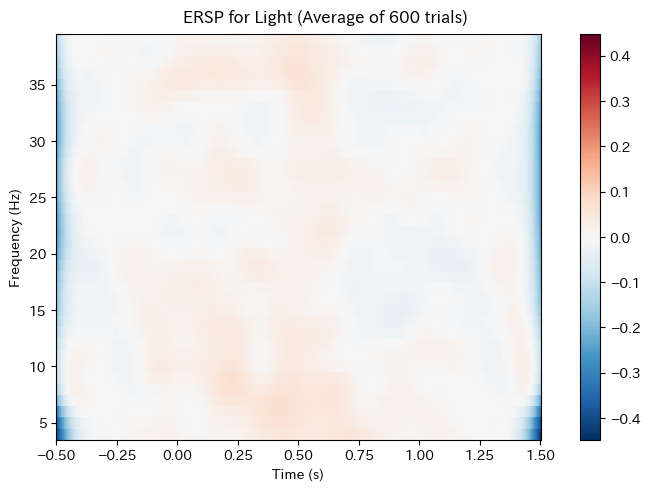

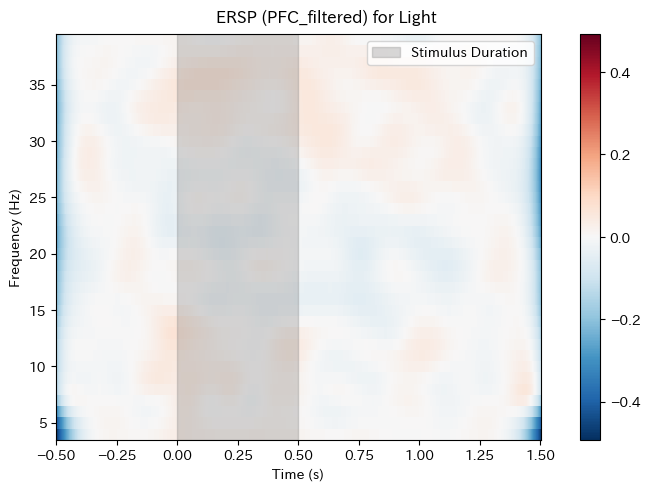

No baseline correction applied


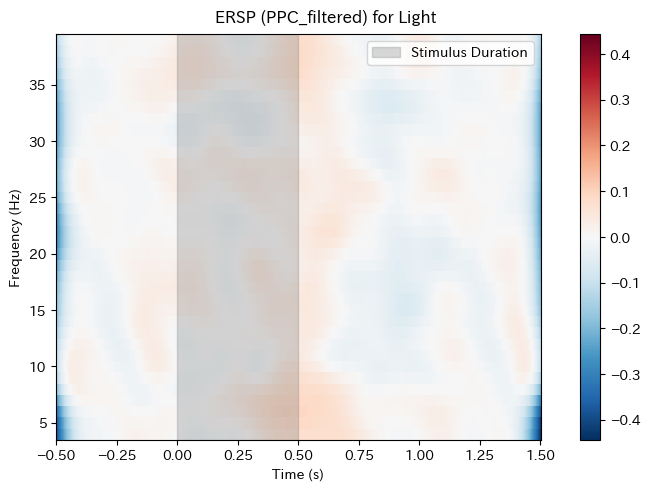

No baseline correction applied


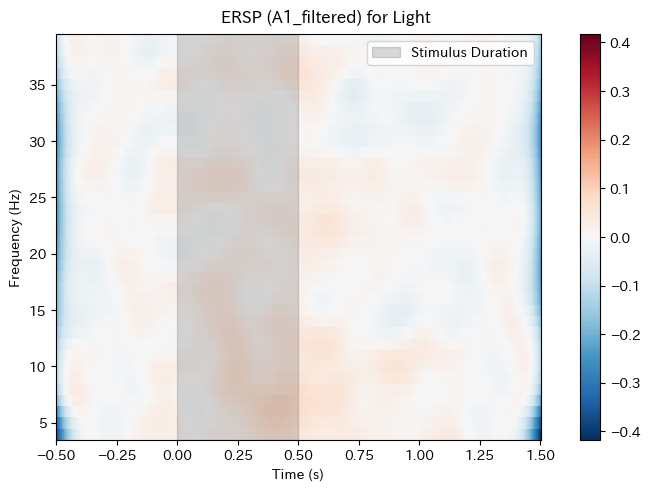

No baseline correction applied


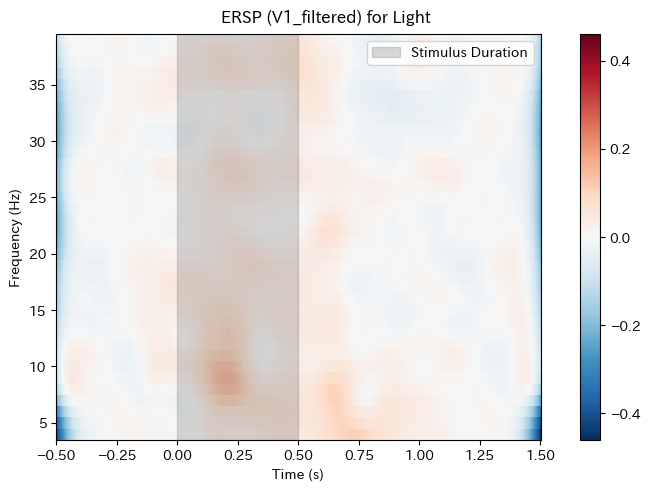


===== Sound の解析中 =====
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied


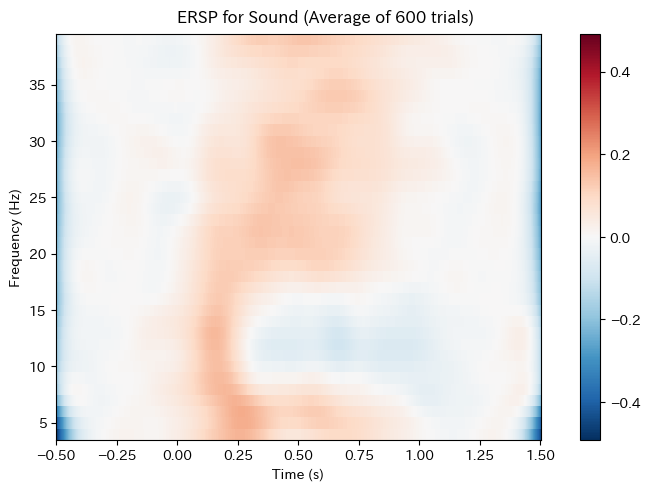

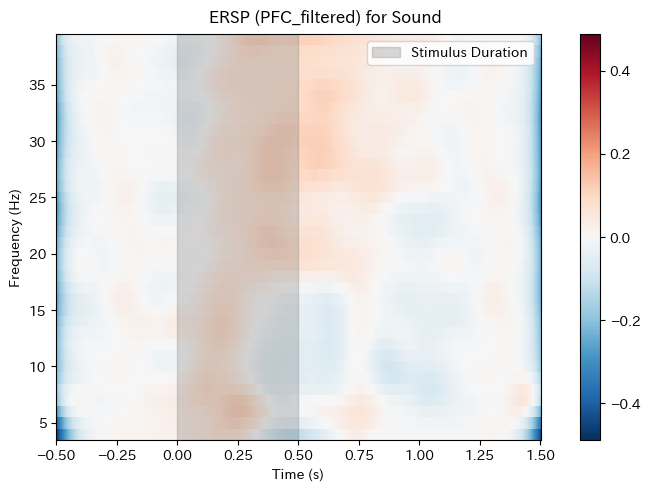

No baseline correction applied


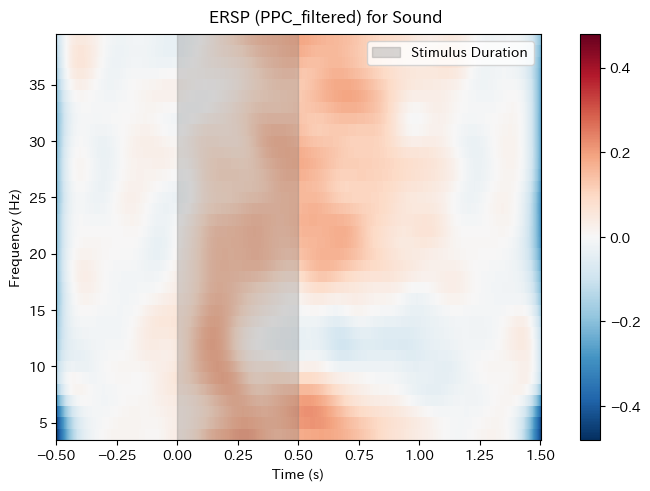

No baseline correction applied


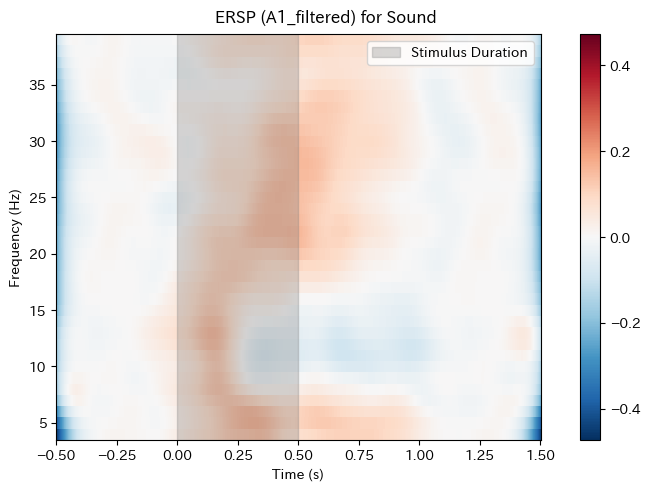

No baseline correction applied


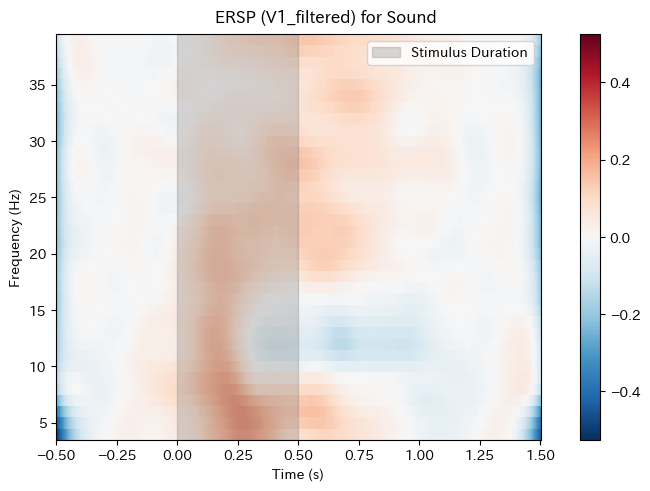


===== Light+Sound の解析中 =====
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied


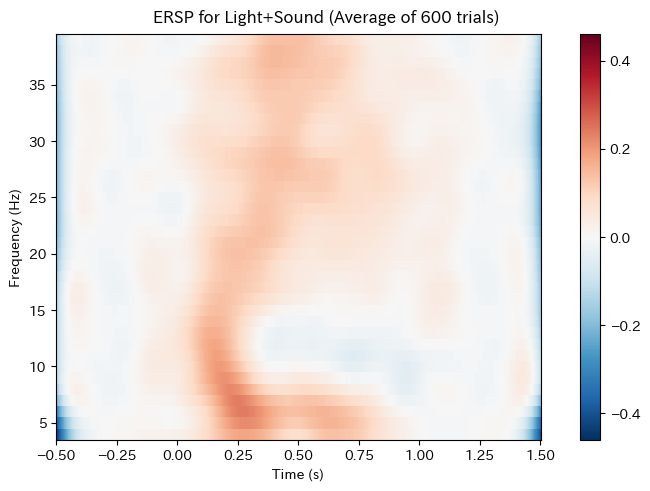

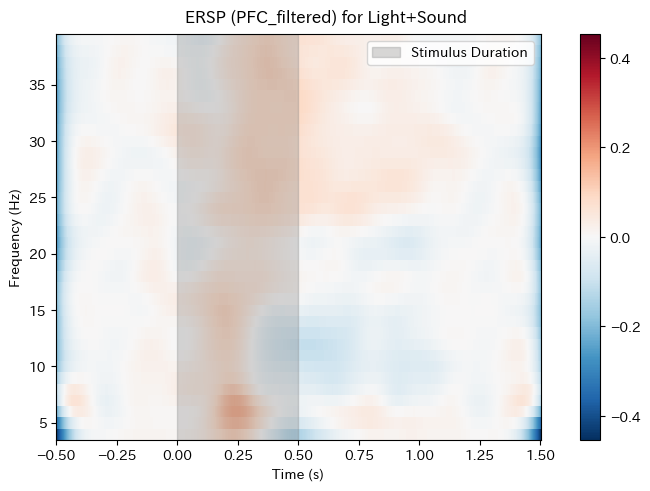

No baseline correction applied


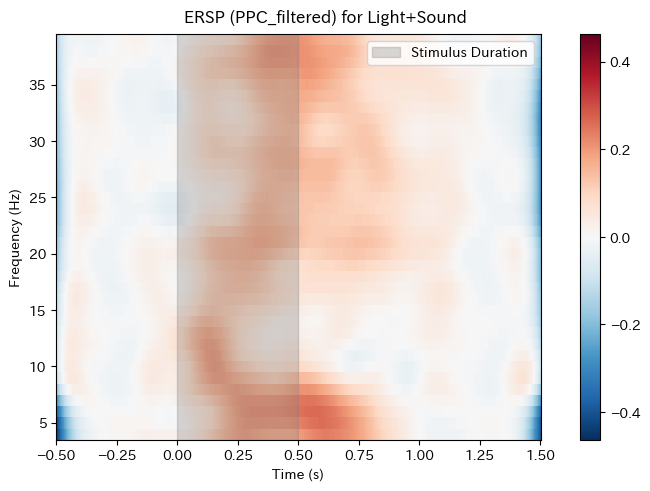

No baseline correction applied


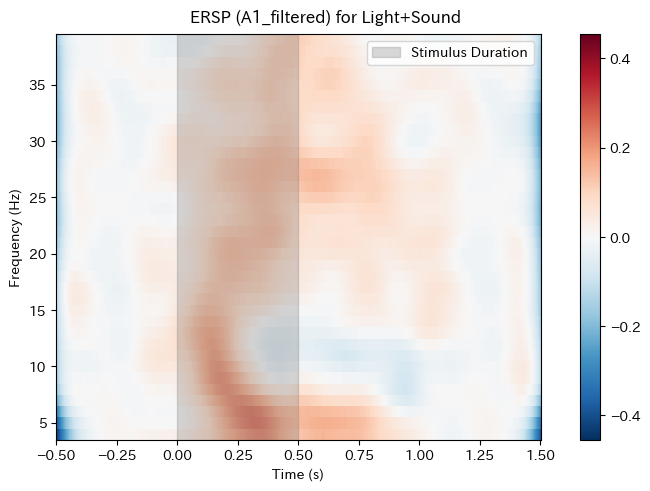

No baseline correction applied


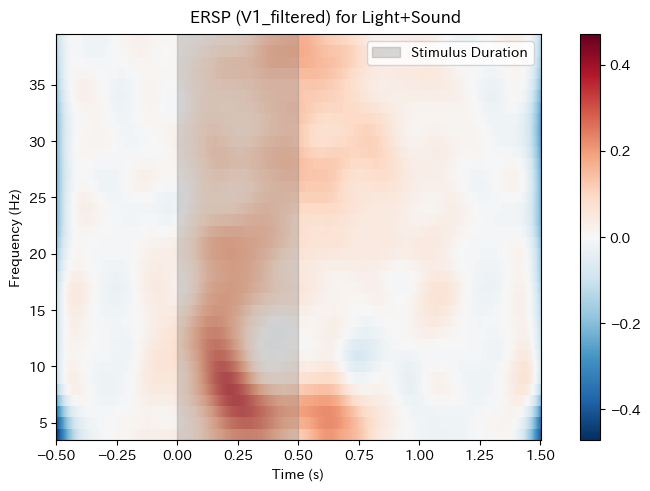


===== No_Stimulus の解析中 =====
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied


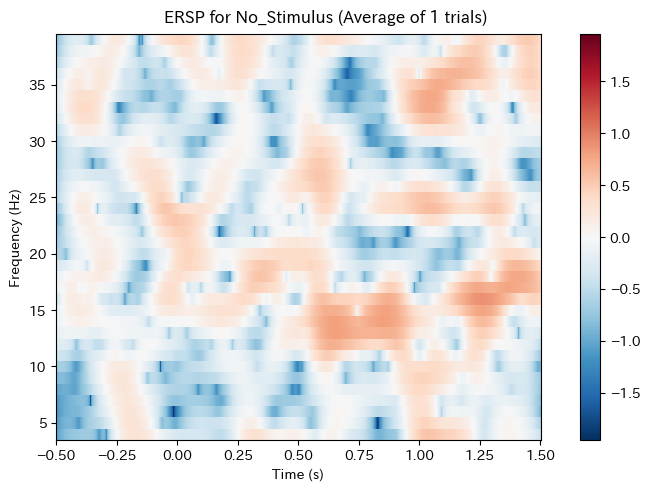

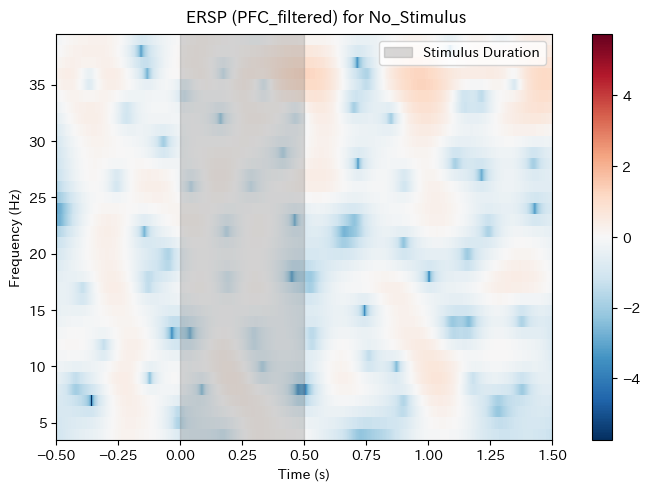

No baseline correction applied


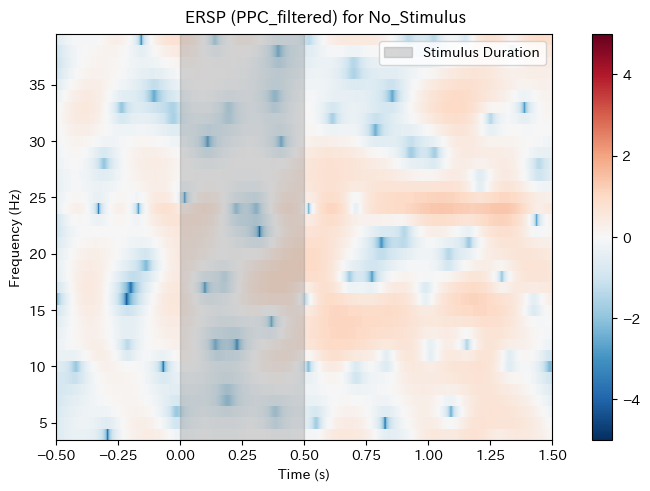

No baseline correction applied


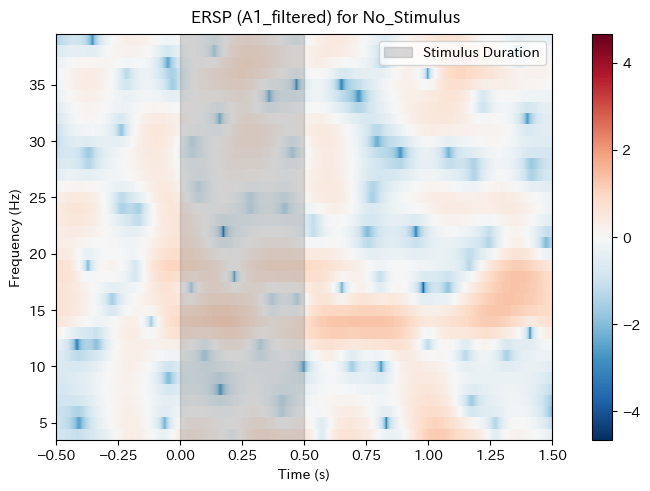

No baseline correction applied


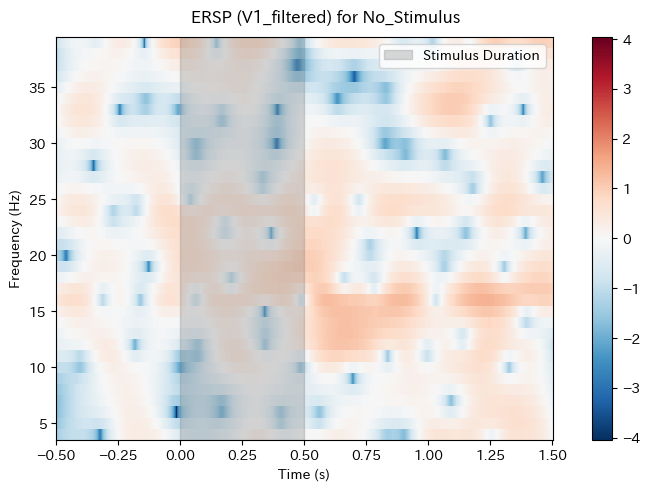


解析完了。


In [7]:
# 6. 時間周波数解析と可視化
# ---------------------------------
# 各刺激タイプと各脳領域についてERSPを計算しプロット
for stim_condition in event_dict.keys():
    print(f"\n===== {stim_condition} の解析中 =====")

    # 特定の刺激条件のエポックを抽出
    epochs_stim = epochs[stim_condition]

    # 時間周波数解析を実行 (Morlet Wavelet)
    tfr = mne.time_frequency.tfr_morlet(epochs_stim,
                                        freqs=freqs,
                                        n_cycles=n_cycles,
                                        use_fft=True,
                                        return_itc=False, # 位相情報は計算しない
                                        average=True,     # 試行全体で平均
                                        picks=channels)

    # ベースライン補正 (デシベル変換)
    tfr.apply_baseline(mode='logratio', baseline=baseline_period)

    # 可視化
    # titleを修正
    fig = tfr.plot(
        picks=channels,
        combine='mean', # チャンネル平均を表示する場合は'mean', 個別の場合はNone
        title=f'ERSP for {stim_condition} (Average of {len(epochs_stim.events)} trials)',
        show=False
    )[0]
    
    
    # 脳領域ごとに個別の図で表示
    # 可視化ループ
    for ch_name in channels:
        # tfr.plot()でFigureオブジェクトを取得
        fig = tfr.plot(
            picks=[ch_name],
            title=f'ERSP ({ch_name}) for {stim_condition}',
            show=False # すぐに表示しない
        )[0]

        # 現在のプロット軸を取得し、刺激区間 (0〜0.5s) にグレーの帯を追加
        ax = fig.gca()
        ax.axvspan(0, 0.5, color='gray', alpha=0.3, label='Stimulus Duration')
        ax.legend() # 凡例を表示

        plt.show() # 修正を加えたプロットを表示

print("\n解析完了。")



In [8]:
import pandas as pd
import numpy as np

# ----------------------------------------------------------------
# 以下に貼り付けて実行してください
# ※ dfがメモリにロードされていることを前提としています
# ----------------------------------------------------------------

print("データフレームから刺激時間と刺激間隔を算出します。")

# サンプリングレートから1サンプルあたりの時間を計算
SAMPLING_RATE = 1000  # Hz
sampling_period = 1.0 / SAMPLING_RATE

# 1. 'Event_ID'が0でない行（＝何らかの刺激がある区間）のみを抽出
stim_df = df[df['Event_ID'] != 0].copy()

if stim_df.empty:
    print("エラー: データ内に刺激区間（Event_IDが0でない行）が見つかりませんでした。")
else:
    # 2. 連続する刺激イベントをグループ化
    # 'Event_ID'が前の行と異なる場合にグループ番号を+1していくことで、
    # 連続した同じIDのブロックを同じグループにする
    stim_df['event_group'] = (stim_df['Event_ID'] != stim_df['Event_ID'].shift()).cumsum()

    # 3. 各イベントグループの開始時刻と終了時刻を取得
    event_summary = stim_df.groupby('event_group')['Time_s'].agg(['first', 'last'])
    event_summary.rename(columns={'first': 'start_time', 'last': 'end_time'}, inplace=True)

    # 4. 刺激時間を計算
    # (終了時刻 - 開始時刻)。最後のサンプル点の時間幅を考慮し、1サンプル時間を加える
    event_summary['duration_s'] = event_summary['end_time'] - event_summary['start_time'] + sampling_period

    # 5. 刺激間隔 (Inter-stimulus Interval) を計算
    # 今回のイベントの開始時刻と、一つ前のイベントの終了時刻の差分
    # .shift(1)で一つ前の行（＝前のイベント）の値を取得する
    event_summary['interval_s'] = event_summary['start_time'] - event_summary['end_time'].shift(1)

    print("\n✅ --- 刺激時間 (Stimulus Duration) の統計 ---")
    # .describe()で平均、標準偏差、最小、最大値などをまとめて表示
    print(event_summary['duration_s'].describe())

    print("\n✅ --- 刺激間隔 (Inter-Stimulus Interval) の統計 ---")
    # 最初のイベントには「前の刺激」がないため、NaN(Not a Number)になるので除外(.dropna())
    print(event_summary['interval_s'].dropna().describe())

データフレームから刺激時間と刺激間隔を算出します。

✅ --- 刺激時間 (Stimulus Duration) の統計 ---
count    1801.000000
mean        0.499664
std         0.006527
min         0.474000
25%         0.498000
50%         0.500000
75%         0.502000
max         0.527000
Name: duration_s, dtype: float64

✅ --- 刺激間隔 (Inter-Stimulus Interval) の統計 ---
count    1800.000000
mean        1.699119
std        19.993676
min         1.013000
25%         1.028000
50%         1.033000
75%         1.036000
max       601.013000
Name: interval_s, dtype: float64


In [ ]:
print(epochs)

<Epochs | 1801 events (all good), -0.5 – 1.5 s (baseline off), ~110.0 MiB, data loaded,
 'Light': 600
 'Sound': 600
 'Light+Sound': 600
 'No_Stimulus': 1>


c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\mne\viz\evoked.py:568: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  fig.canvas.draw()  # for axes plots update axes.
c:\Users\dmasu\OneDrive\デスクトップ\pcdh_analyze\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


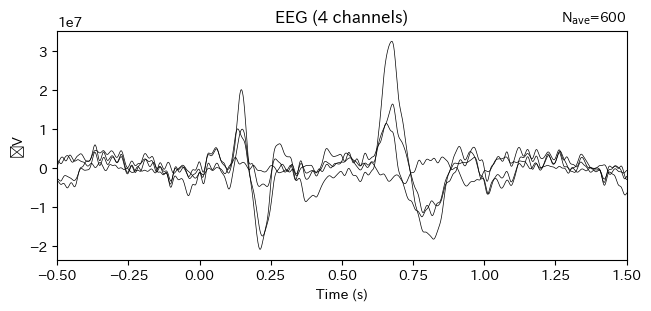

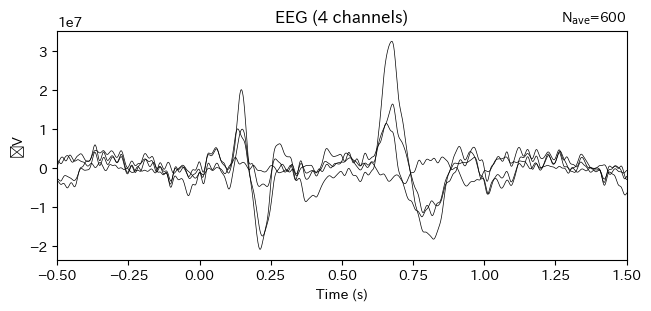

In [11]:
# 'Light' 条件のERPをプロット
epochs['Light'].average().plot(window_title='ERP for Light stimulus')

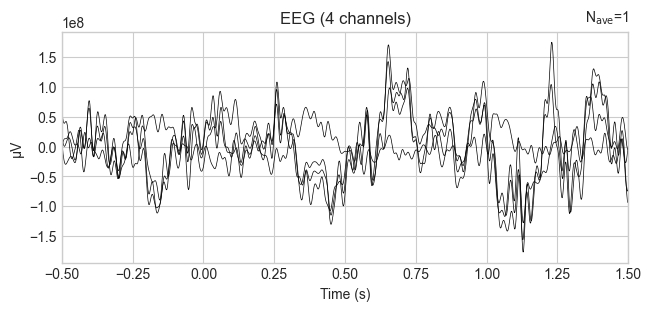

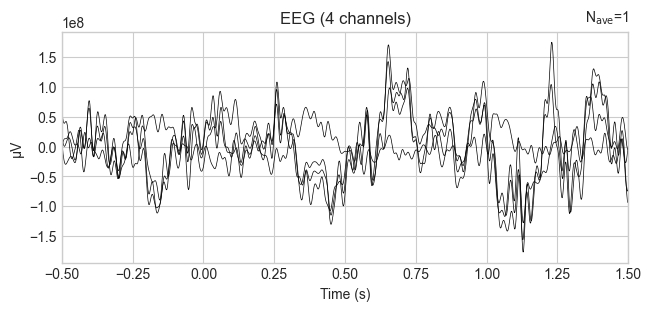

In [22]:
# 'Light' 条件のERPをプロット
epochs['No_Stimulus'].average().plot(window_title='ERP for Light stimulus')

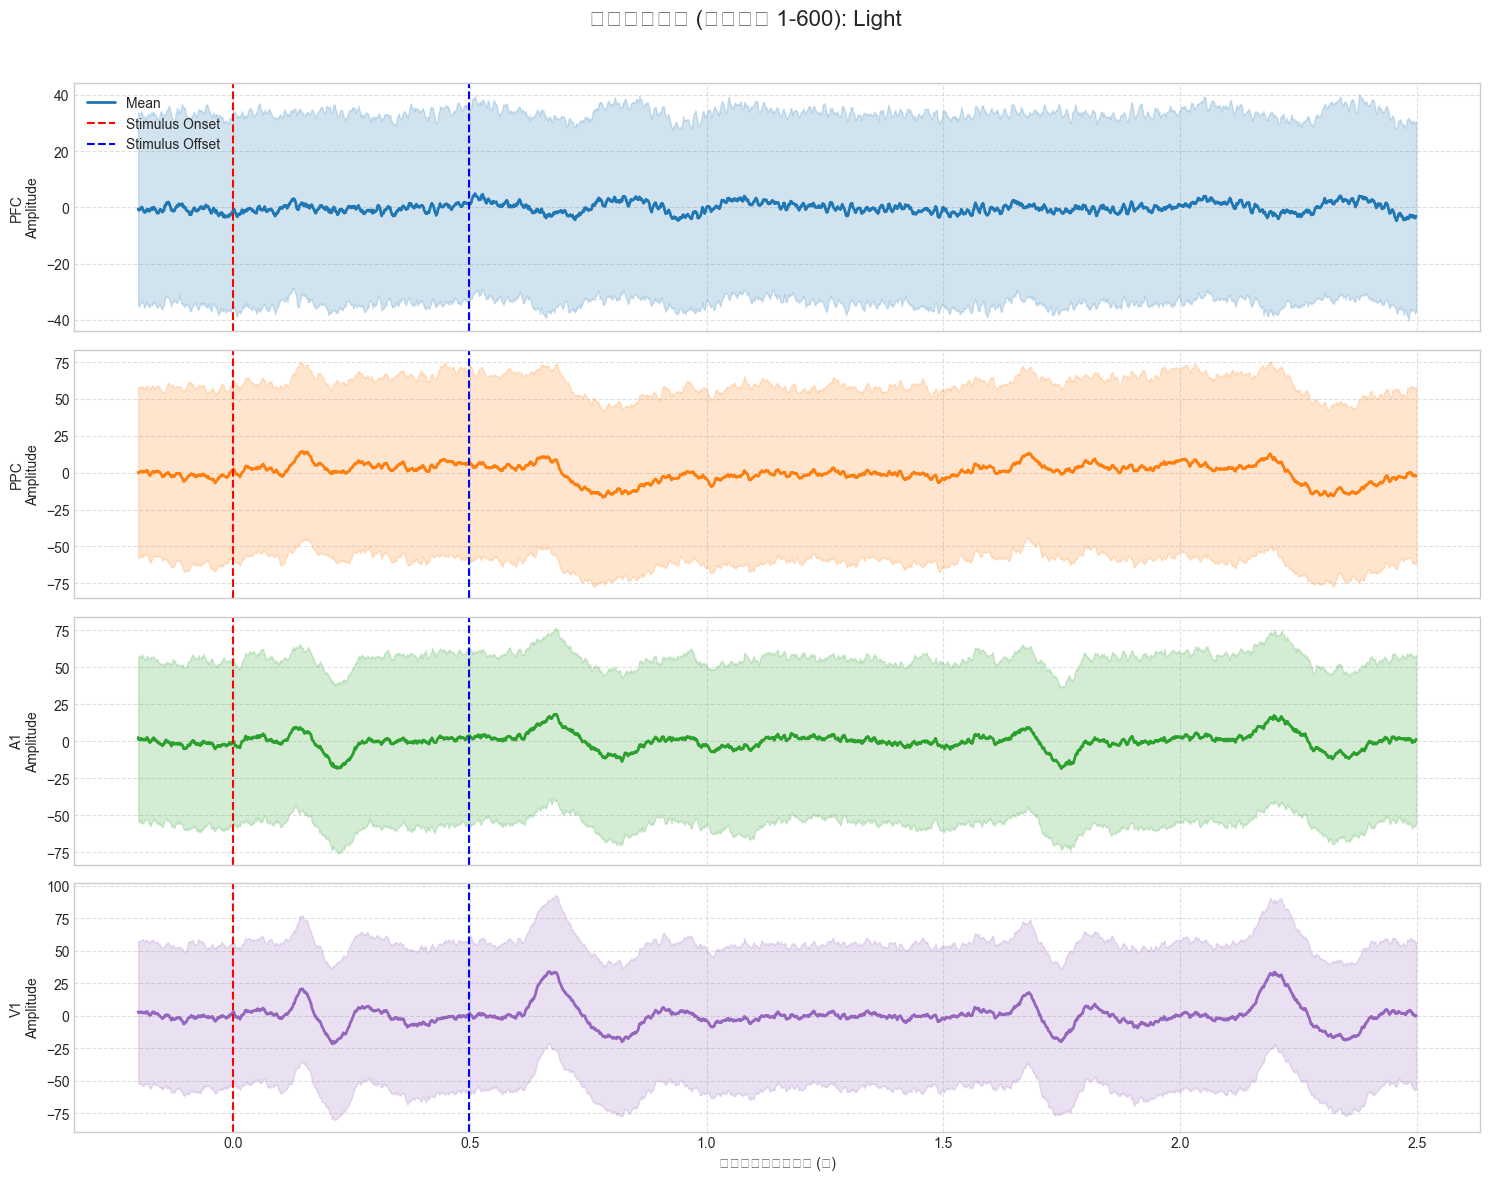

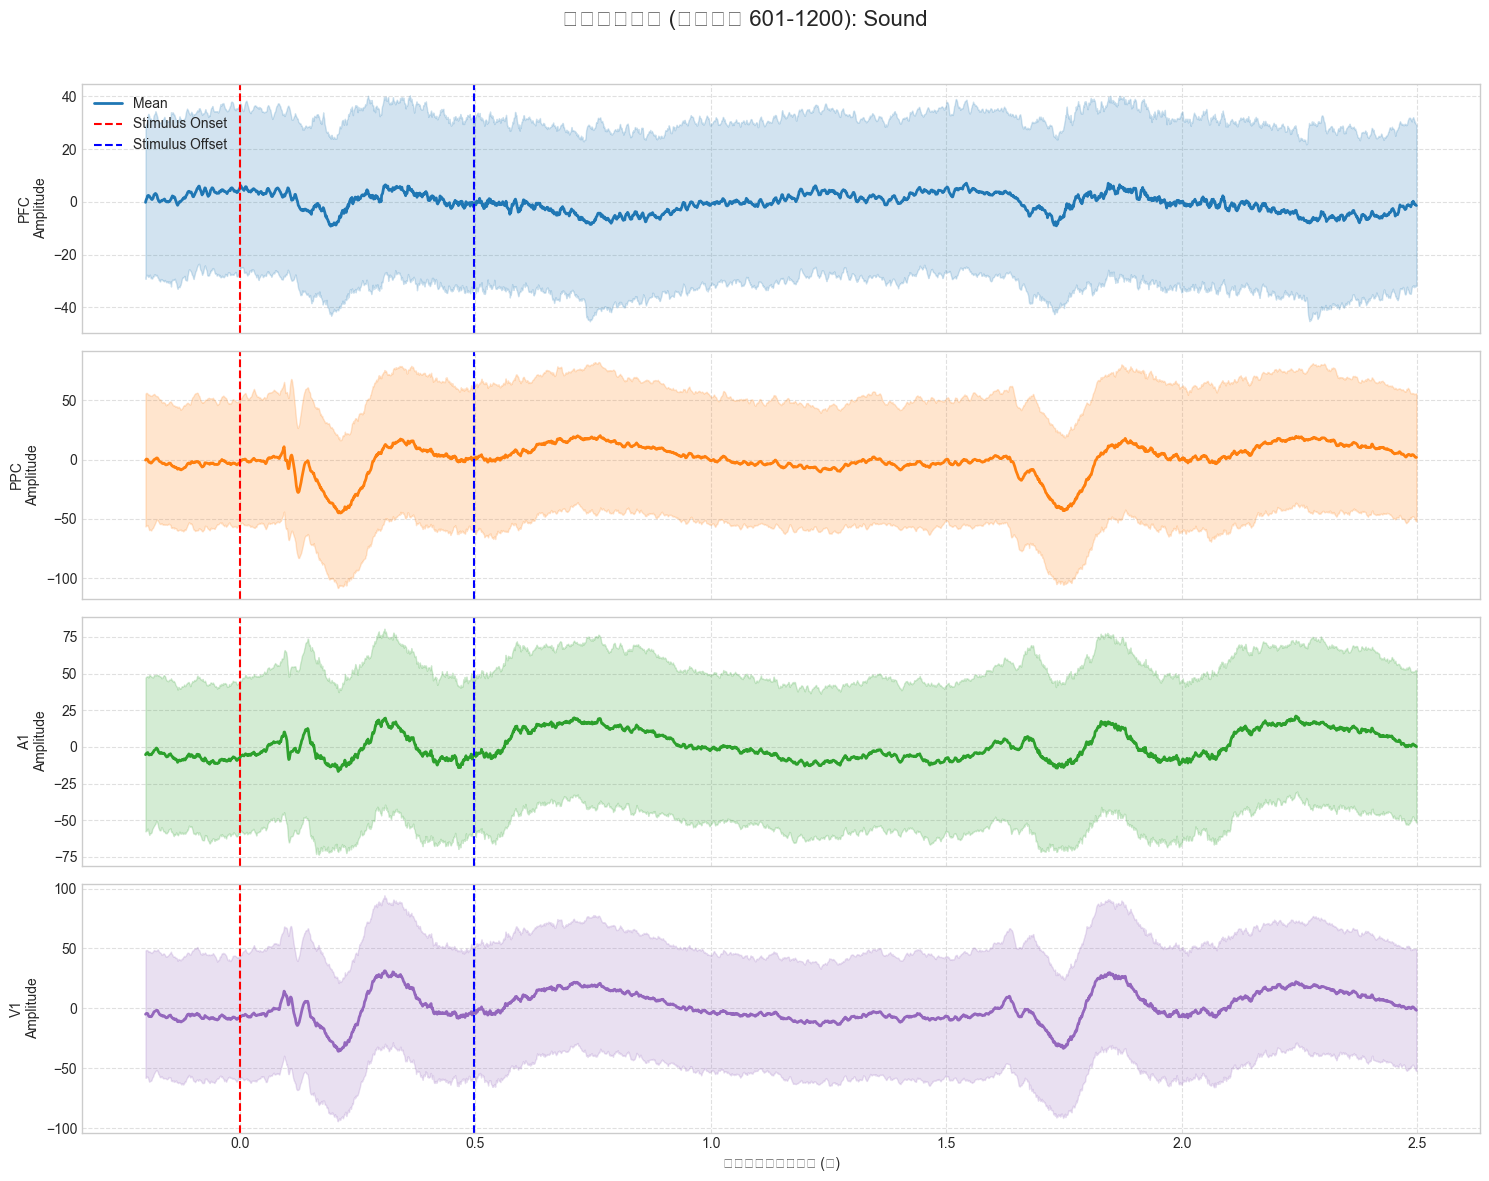

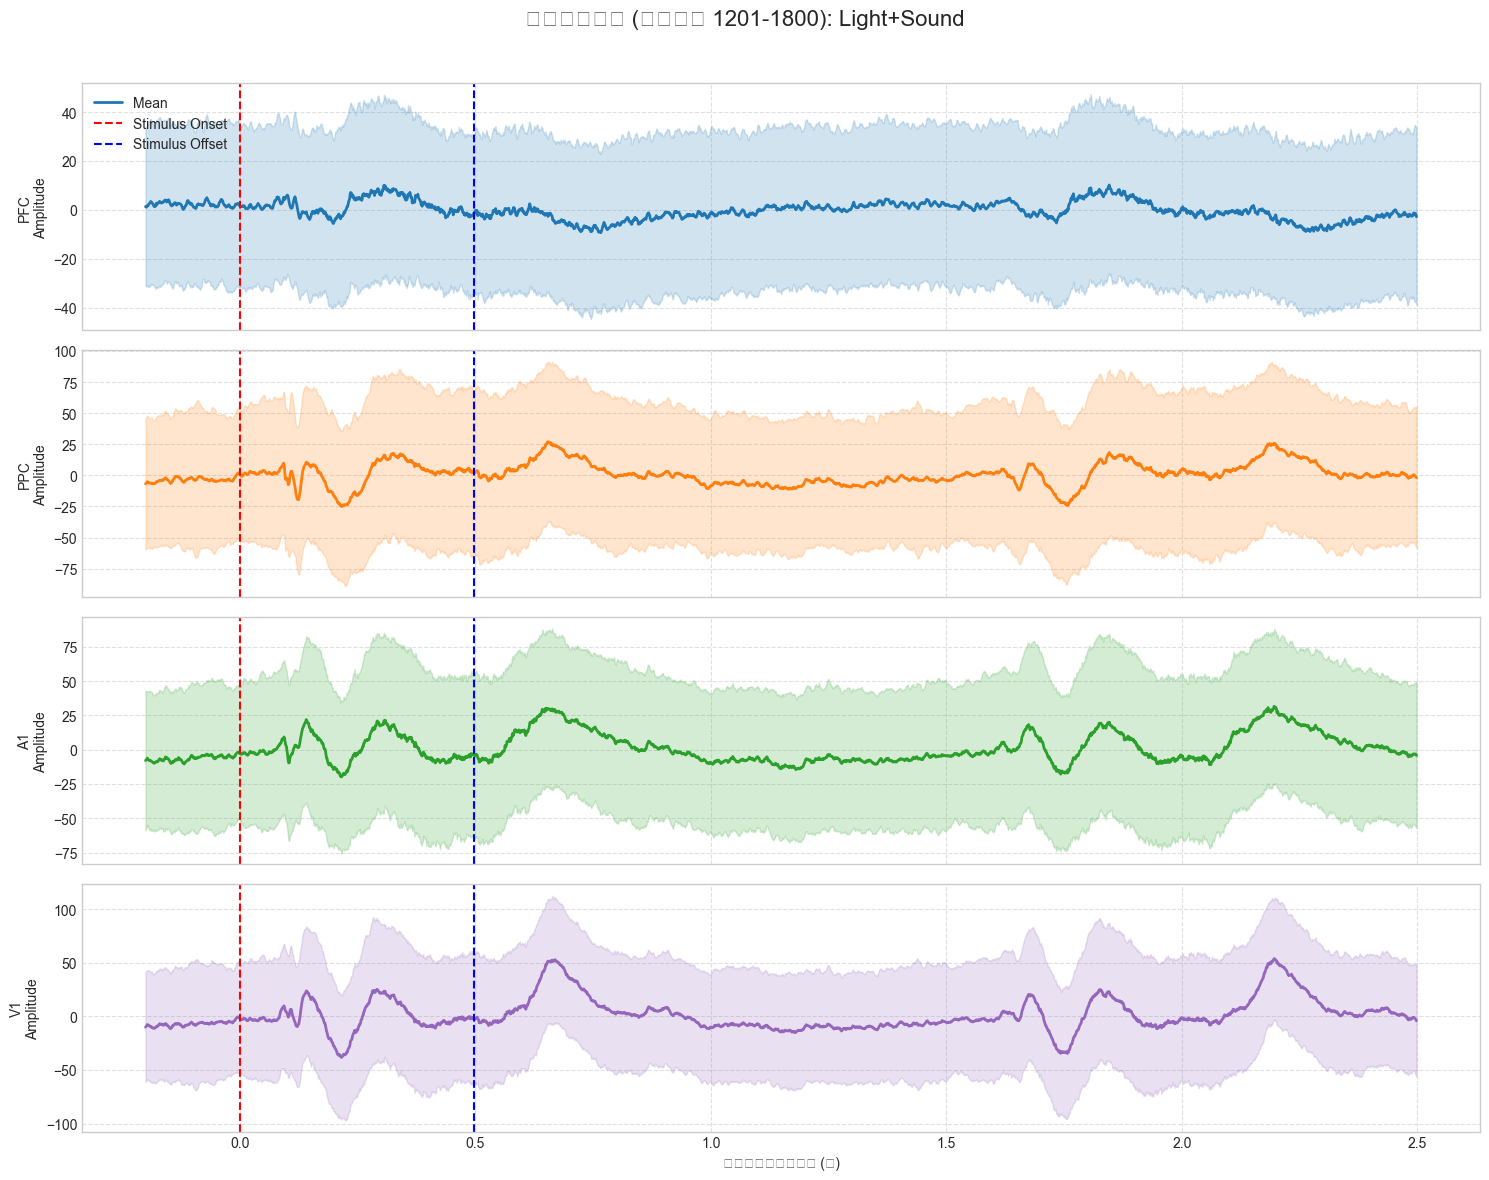

In [20]:
import sys
import japanize_matplotlib
# このNotebook（01_eda.ipynb）から見て、
# 親ディレクトリ（project_root）をPythonの検索パスに追加します。
# これにより、srcフォルダの中のモジュールをインポートできるようになります。
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- 作成したモジュールから関数をインポート ---
from src.plot_utils import plot_erp_with_dynamic_window

# 1. Light刺激 (イベントID 1-600)
plot_erp_with_dynamic_window(df, 
                             start_id=1, 
                             end_id=600, 
                             post_offset_ms=2000,
                             title="加算平均波形 (イベント 1-600): Light")

# 2. Sound刺激 (イベントID 601-1200)
plot_erp_with_dynamic_window(df, 
                             start_id=601, 
                             end_id=1200, 
                             post_offset_ms=2000,
                             title="加算平均波形 (イベント 601-1200): Sound")

# 3. Light+Sound刺激 (イベントID 1201-1800)
plot_erp_with_dynamic_window(df, 
                             start_id=1201, 
                             end_id=1800, 
                             post_offset_ms=2000,
                             title="加算平均波形 (イベント 1201-1800): Light+Sound")


ITPCの計算を開始します...

処理中の刺激: Light
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").

処理中の刺激: Sound
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").

処理中の刺激: Light+Sound
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").

処理中の刺激: No_Stimulus
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").

全刺激タイプのITPC計算が完了しました。

結果をプロットします...
Applying baseline correction (mode: zscore)
No baseline correction applied


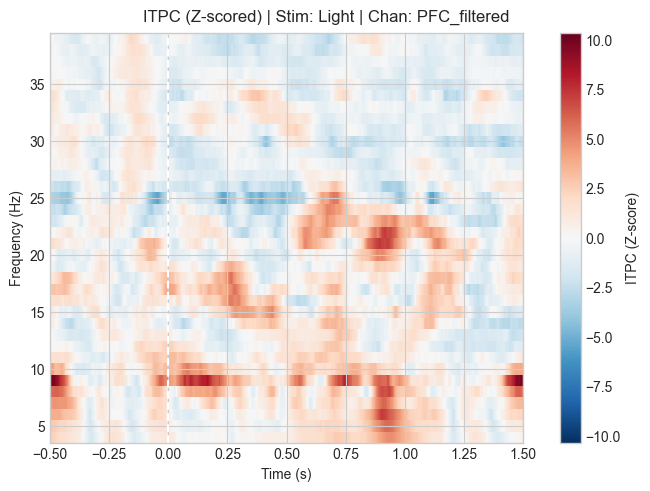

No baseline correction applied


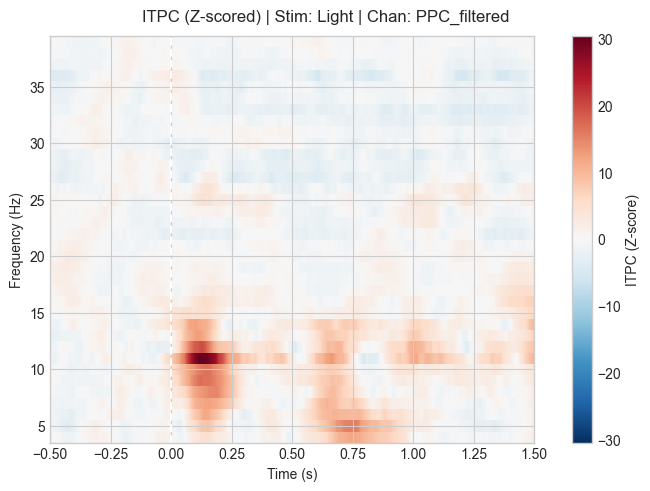

No baseline correction applied


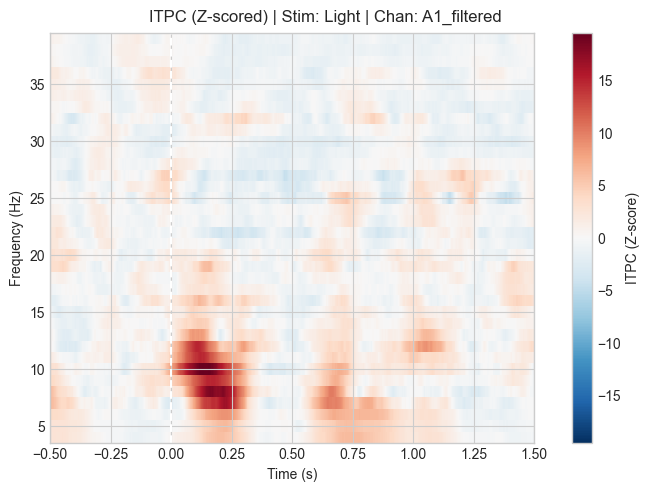

No baseline correction applied


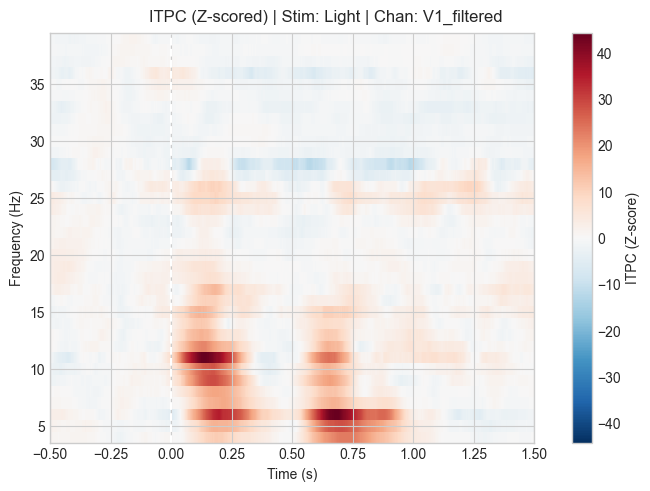

Applying baseline correction (mode: zscore)
No baseline correction applied


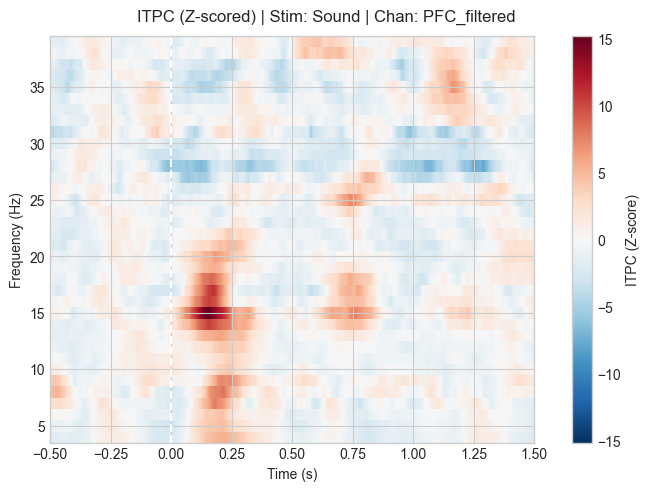

No baseline correction applied


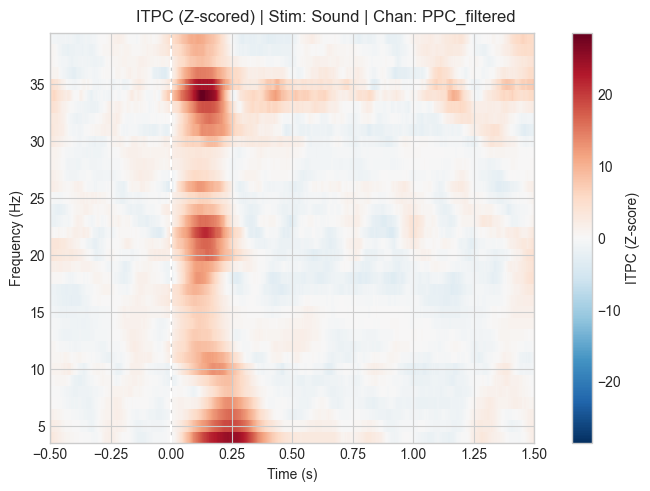

No baseline correction applied


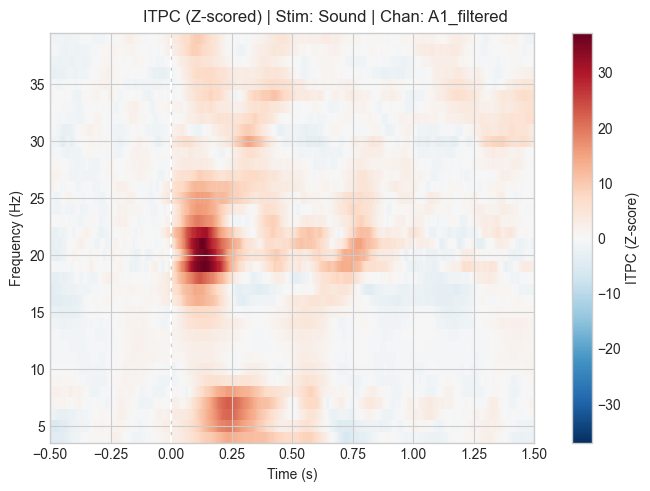

No baseline correction applied


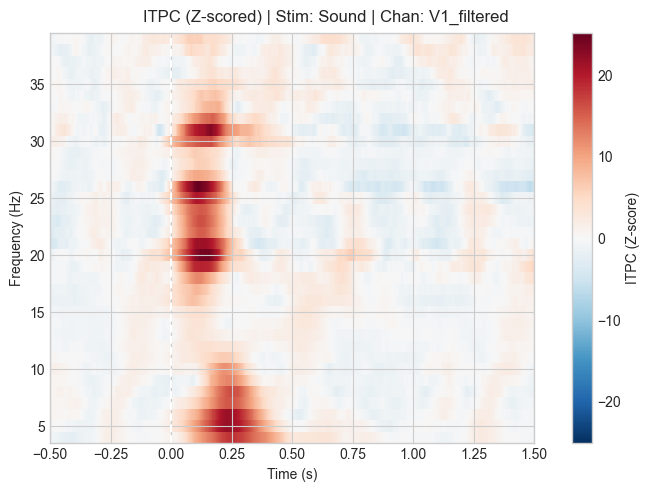

Applying baseline correction (mode: zscore)
No baseline correction applied


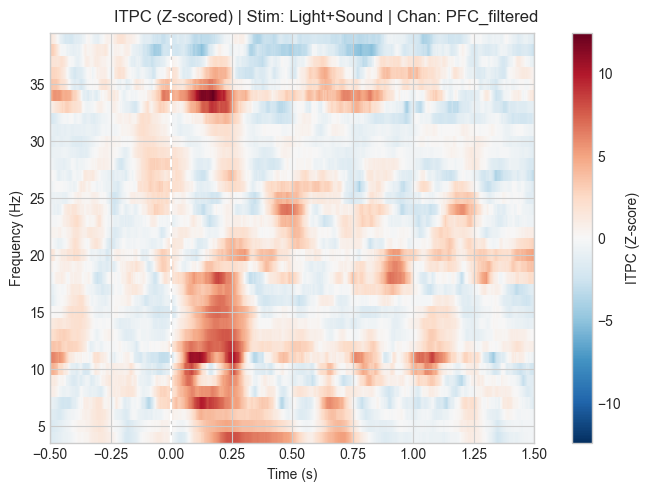

No baseline correction applied


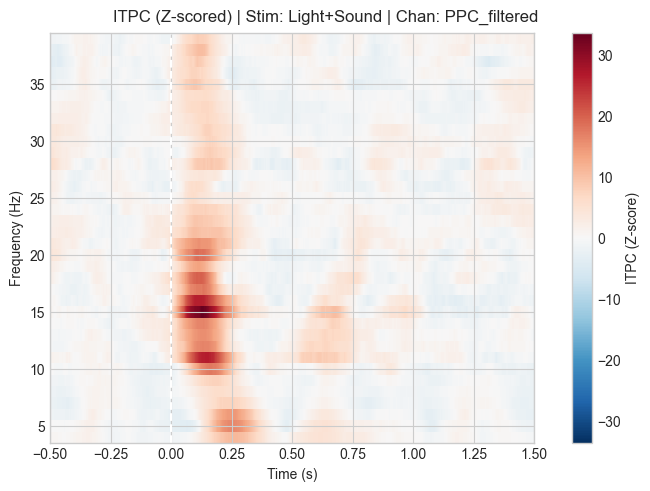

No baseline correction applied


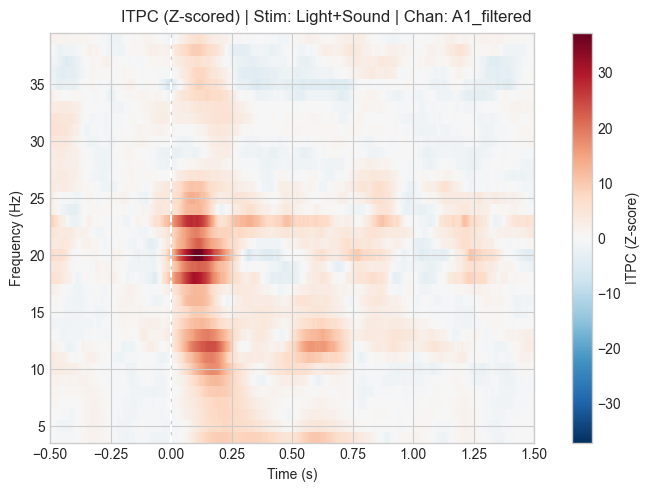

No baseline correction applied


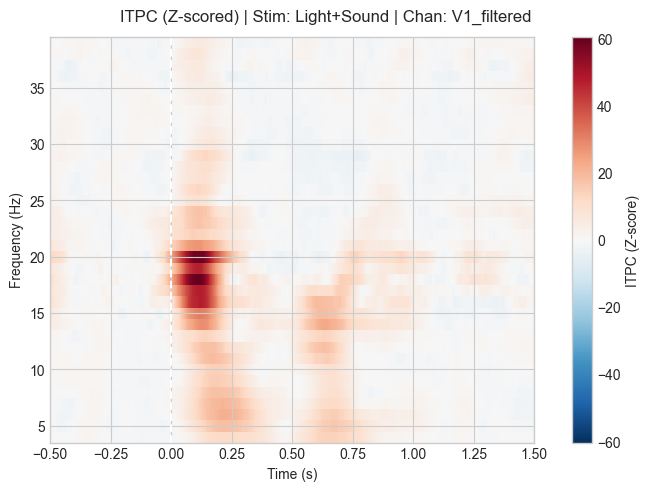

Applying baseline correction (mode: zscore)
No baseline correction applied


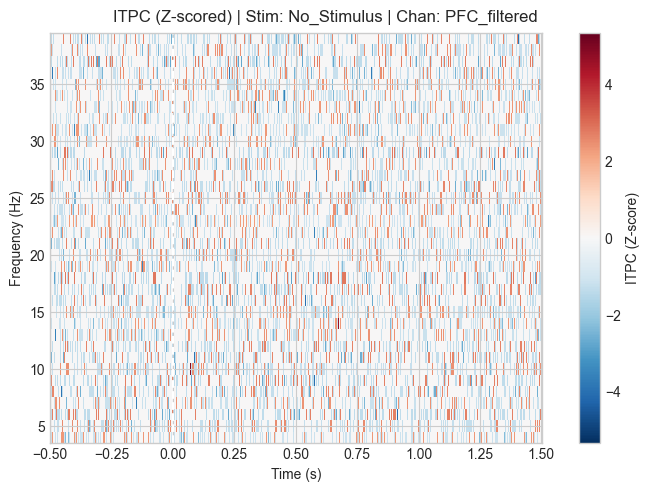

No baseline correction applied


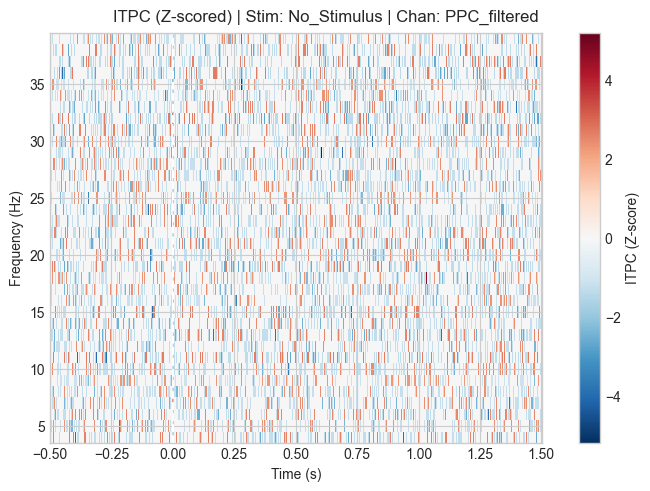

No baseline correction applied


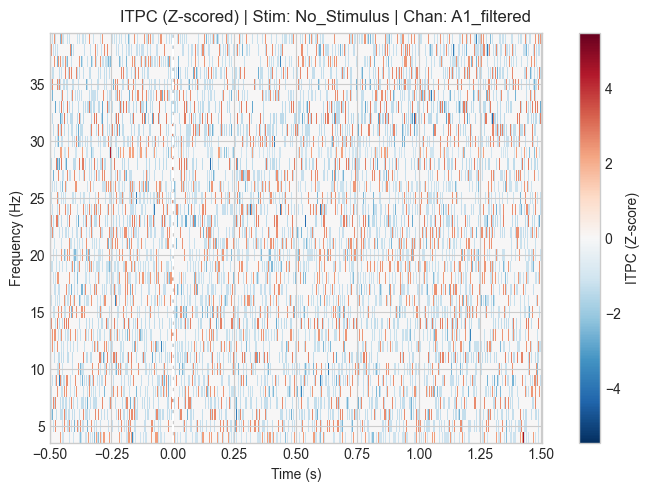

No baseline correction applied


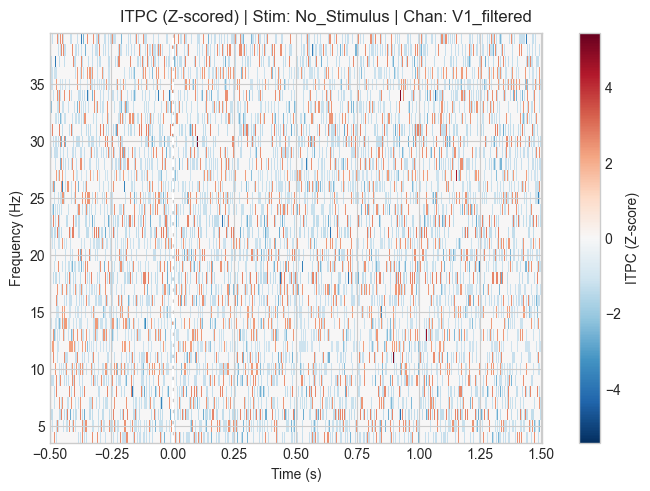

In [ ]:
# ==============================================================================
# 6. ITPCの計算と可視化
# ==============================================================================
print("\nITPCの計算を開始します...")

# 結果を格納する辞書
itpc_results = {}

# 各刺激タイプごとにループ
for stim_condition in epochs.event_id.keys():
    print(f"\n処理中の刺激: {stim_condition}")
    
    # 該当する刺激のエポックを抽出
    epochs_stim = epochs[stim_condition]
    
    # モルレウェーブレット変換を用いて、事象関連パワー(ERP)とITPCを同時に計算
    # return_itc=True にすることでITPCが計算される
    tfr, itpc = mne.time_frequency.tfr_morlet(epochs_stim,
                                              freqs=freqs,
                                              n_cycles=n_cycles,
                                              use_fft=True,
                                              return_itc=True,
                                              average=True, # 全試行で平均
                                              verbose=False)
    
    # 計算されたITPCを辞書に保存
    itpc_results[stim_condition] = itpc

print("\n全刺激タイプのITPC計算が完了しました。")


# ---------------------------------
# 7. 結果の可視化 (修正版)
# ---------------------------------
print("\n結果をプロットします...")

for stim_condition, itpc in itpc_results.items():
    itpc.apply_baseline(baseline=baseline_period, mode='zscore')
    
    for ch_idx, ch_name in enumerate(channels):
        # itpc.plot()は図のリストを返すため、figsという変数で受け取る
        figs = itpc.plot(picks=[ch_idx], 
                         show=False, 
                         title=f'ITPC (Z-scored) | Stim: {stim_condition} | Chan: {ch_name}')
        
        # リストの最初の要素（インデックス0）が目的の図（Figureオブジェクト）
        fig = figs[0] 
        
        # これで fig は Figureオブジェクトなので、.axes で軸にアクセスできる
        fig.axes[0].axvline(0, color='white', linestyle='--', linewidth=1.5)
        fig.axes[0].set_ylabel('Frequency (Hz)')
        fig.axes[0].set_xlabel('Time (s)')
        fig.axes[1].set_ylabel('ITPC (Z-score)')
        
        # 最後に図を表示
        plt.show()

In [27]:
pip install mne-connectivity

   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.1 MB ? eta -:--:--
   - -----------------------------

In [ ]:
# MNE-Connectivityライブラリから必要な関数をインポート
from mne_connectivity import spectral_connectivity_epochs 
# MNE本体の可視化機能はそのまま
# from mne.viz import plot_connectivity_circle

# 1. wPLIの計算
# ---------------------------------
# 計算方法として'wpli'を指定
con_method = 'wpli'

# 各刺激条件のwPLI計算結果を格納する辞書
wpli_results = {}

# event_dictに含まれる各刺激条件でループ
for stim_condition in event_dict.keys():
    print(f"Calculating wPLI for condition: '{stim_condition}'...")
    
    # MNEの関数を使ってwPLIを計算
    # spectral_connectivity_epochsはSpectralConnectivityオブジェクトを返す
    con = spectral_connectivity_epochs(
        epochs[stim_condition],        # 条件で絞ったエポックデータ
        method=con_method,
        mode='multitaper',             # 推定モード（頑健な結果が得られやすい）
        sfreq=sfreq,
        fmin=freqs.min(),              # 解析する最小周波数
        fmax=freqs.max(),              # 解析する最大周波数
        faverage=False,                # 周波数帯で平均しない（周波数分解能を維持）
        mt_adaptive=True,              # multitaperの適応的重み付けを有効化
        n_jobs=1                       # 並列計算のプロセス数（-1で利用可能な全CPUを使用）
    )
    
    # 結果を辞書に保存
    wpli_results[stim_condition] = con

print("\nwPLI calculation finished for all conditions.")

Calculating wPLI for condition: 'Light'...
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 6 connections
    using t=-0.500s..1.500s for estimation (2001 points)
    frequencies: 4.5Hz..39.0Hz (70 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: WPLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    c

TypeError: '>=' not supported between instances of 'list' and 'int'

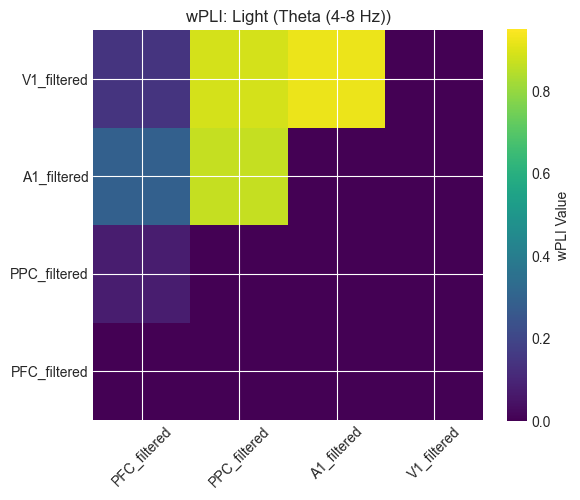

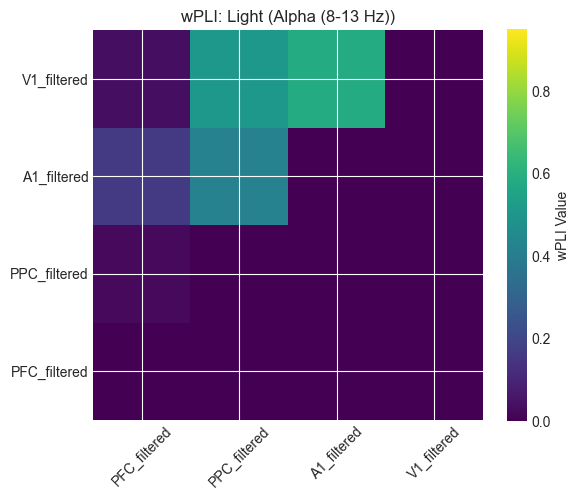

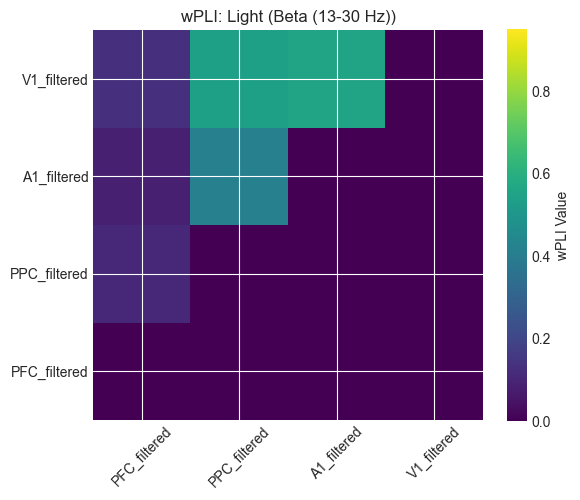

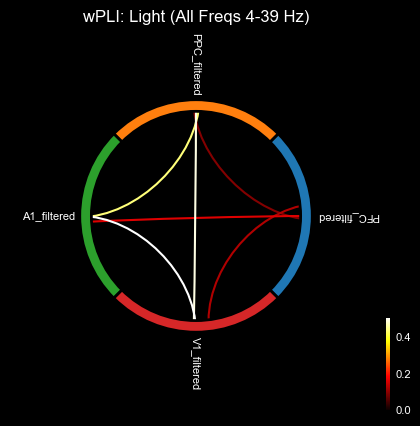

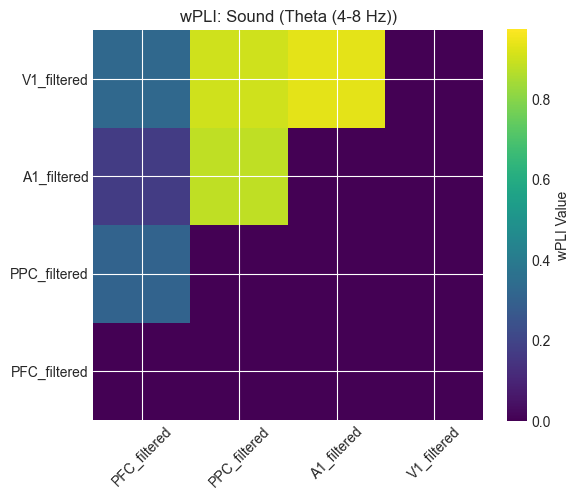

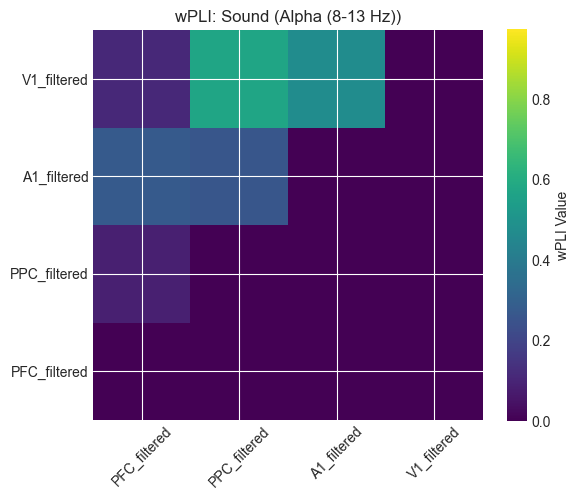

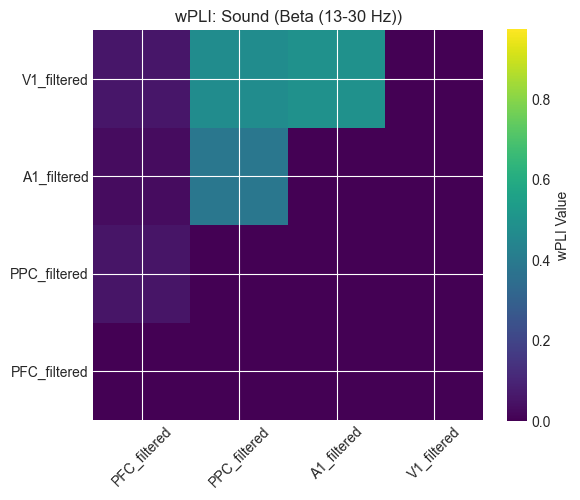

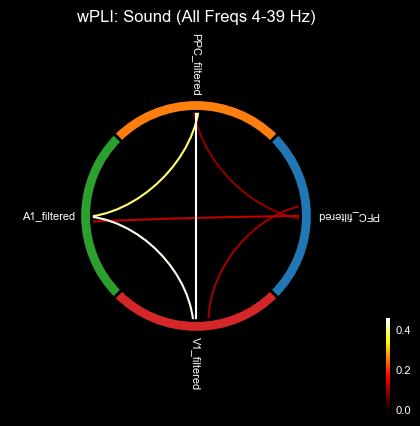

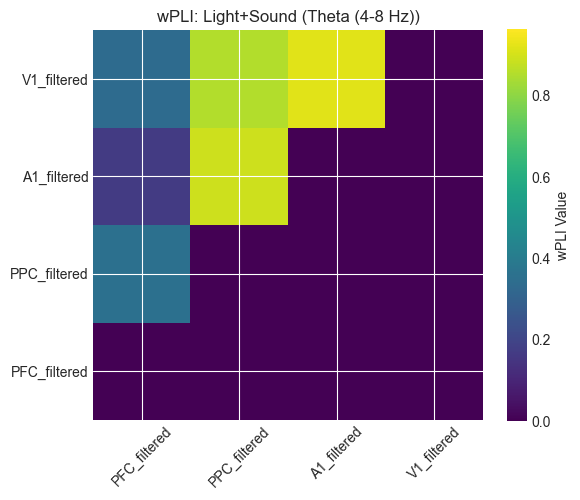

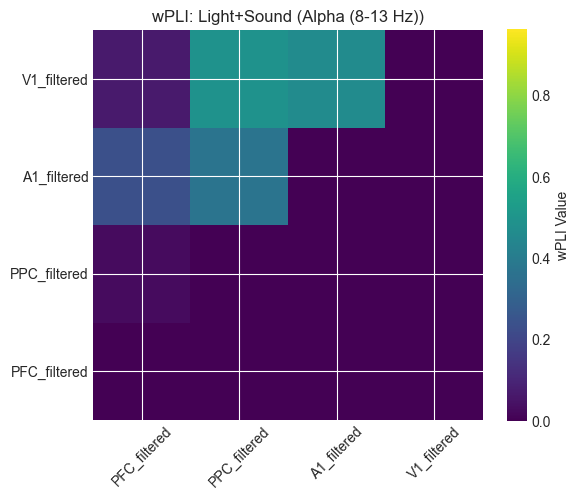

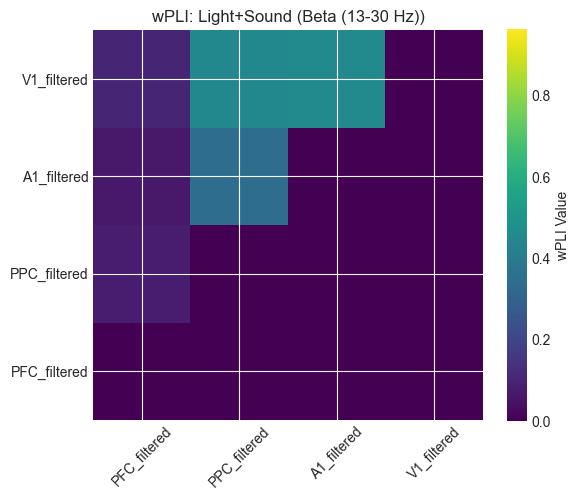

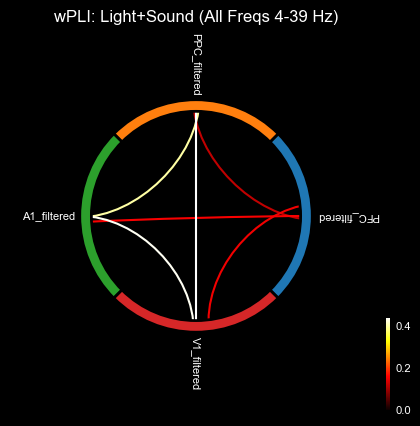

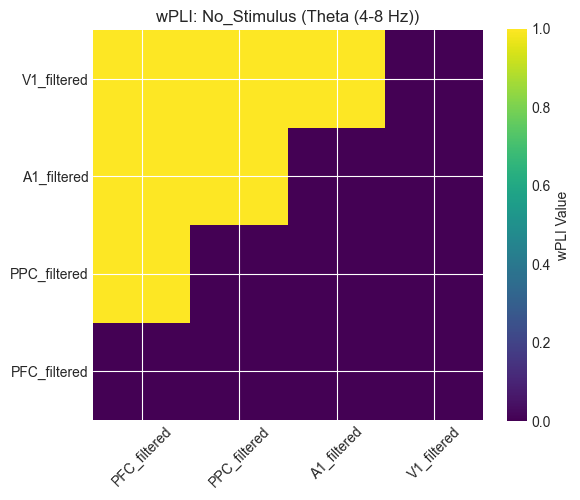

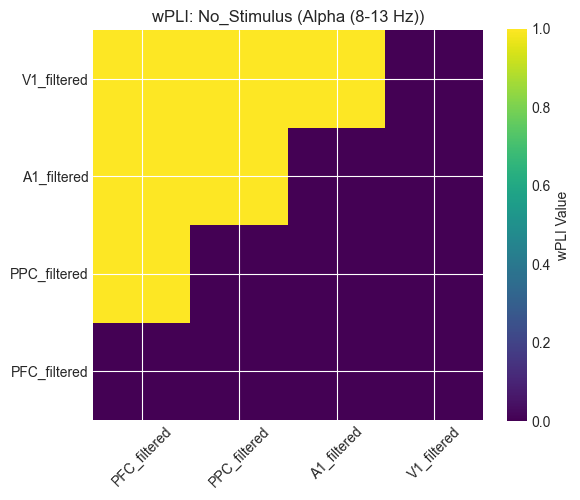

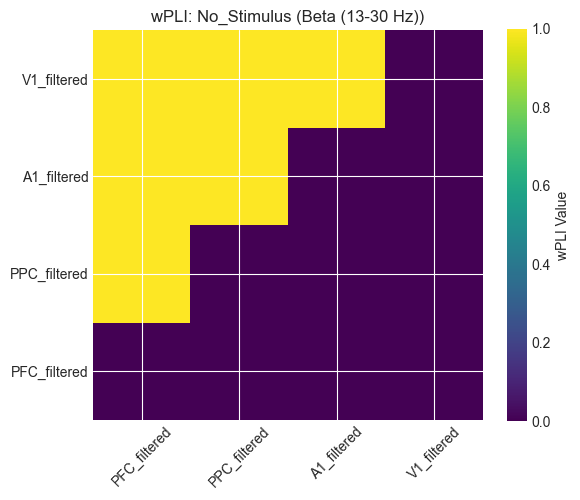

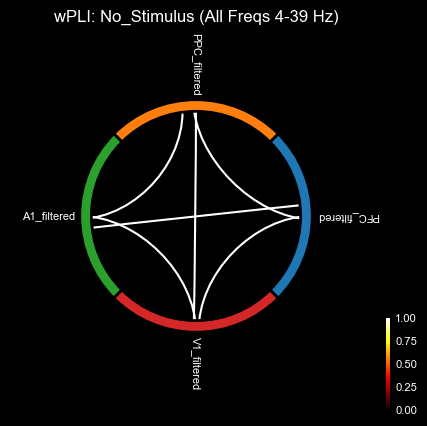

In [45]:
# 2. 結果の可視化
# ---------------------------------
# 脳領域のラベルを取得
ch_names = epochs.ch_names

# 解析したい周波数帯を定義
freq_bands = {
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30)
}

# 各刺激条件についてプロット
for stim_condition, con in wpli_results.items():
    
    # 可視化のためにSpectralConnectivityオブジェクトからデータを取得
    # get_data()の出力は (n_channels * (n_channels - 1) / 2, n_freqs)
    # 'dense'を指定すると (n_channels, n_channels, n_freqs) の正方行列になる
    wpli_matrix_full = con.get_data('dense')
    
    # プロットする周波数帯をループ
    for band_name, (fmin, fmax) in freq_bands.items():
        
        # 周波数帯のインデックスを検索
        freqs_array = np.array(con.freqs)
        freq_indices = np.where((freqs_array >= fmin) & (freqs_array < fmax))[0]        
        
        # 指定した周波数帯でwPLIを平均
        wpli_matrix_band = wpli_matrix_full[:, :, freq_indices].mean(axis=2)
        
        # ヒートマップで可視化
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(wpli_matrix_band, cmap='viridis', origin='lower', vmin=0, vmax=np.max(wpli_matrix_full))
        
        # ラベル、タイトル、カラーバーを設定
        ax.set_xticks(np.arange(len(ch_names)))
        ax.set_yticks(np.arange(len(ch_names)))
        ax.set_xticklabels(ch_names, rotation=45)
        ax.set_yticklabels(ch_names)
        ax.set_title(f"wPLI: {stim_condition} ({band_name})")
        
        # カラーバーを追加
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('wPLI Value')
        
        plt.tight_layout()
        plt.show()
        
    # --- 全周波数(4-39Hz)で平均した円形コネクトグラム ---

    from mne_connectivity.viz import plot_connectivity_circle

    # wpli_resultsのループ (これは既存のコード)
    # for stim_condition, con in wpli_results.items():
    #    ... (このブロックをループの内側に置く)

    # 1. (4, 4, 36周波数) の行列を取得
    wpli_matrix_full = con.get_data('dense')

    # 2. 周波数軸 (axis=2) 全体で平均し、(4, 4) の行列にする
    wpli_matrix_all_freqs = np.mean(wpli_matrix_full, axis=2)

    # 3. プロットのタイトル
    plot_title = f"wPLI: {stim_condition} (All Freqs 4-39 Hz)"

    # 4. 可視化
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black', subplot_kw=dict(polar=True))

    plot_connectivity_circle(
        wpli_matrix_all_freqs,     # 全周波数で平均した行列を使用
        node_names=ch_names,
        indices=None,
        node_colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
        title=plot_title,
        facecolor='black',
        textcolor='white',
        n_lines=None,              # 線の本数を制限しない
        vmin=0.0,                  # 0以上のwPLI値をすべて描画
        ax=ax,
        show=False
    )
    plt.show()

    # ... (wpli_resultsのループが続く)

Plotting for 6 channel pairs.
Frequency axis loaded (Type: <class 'numpy.ndarray'>, Min: 4.497751124437781, Max: 38.980509745127435)


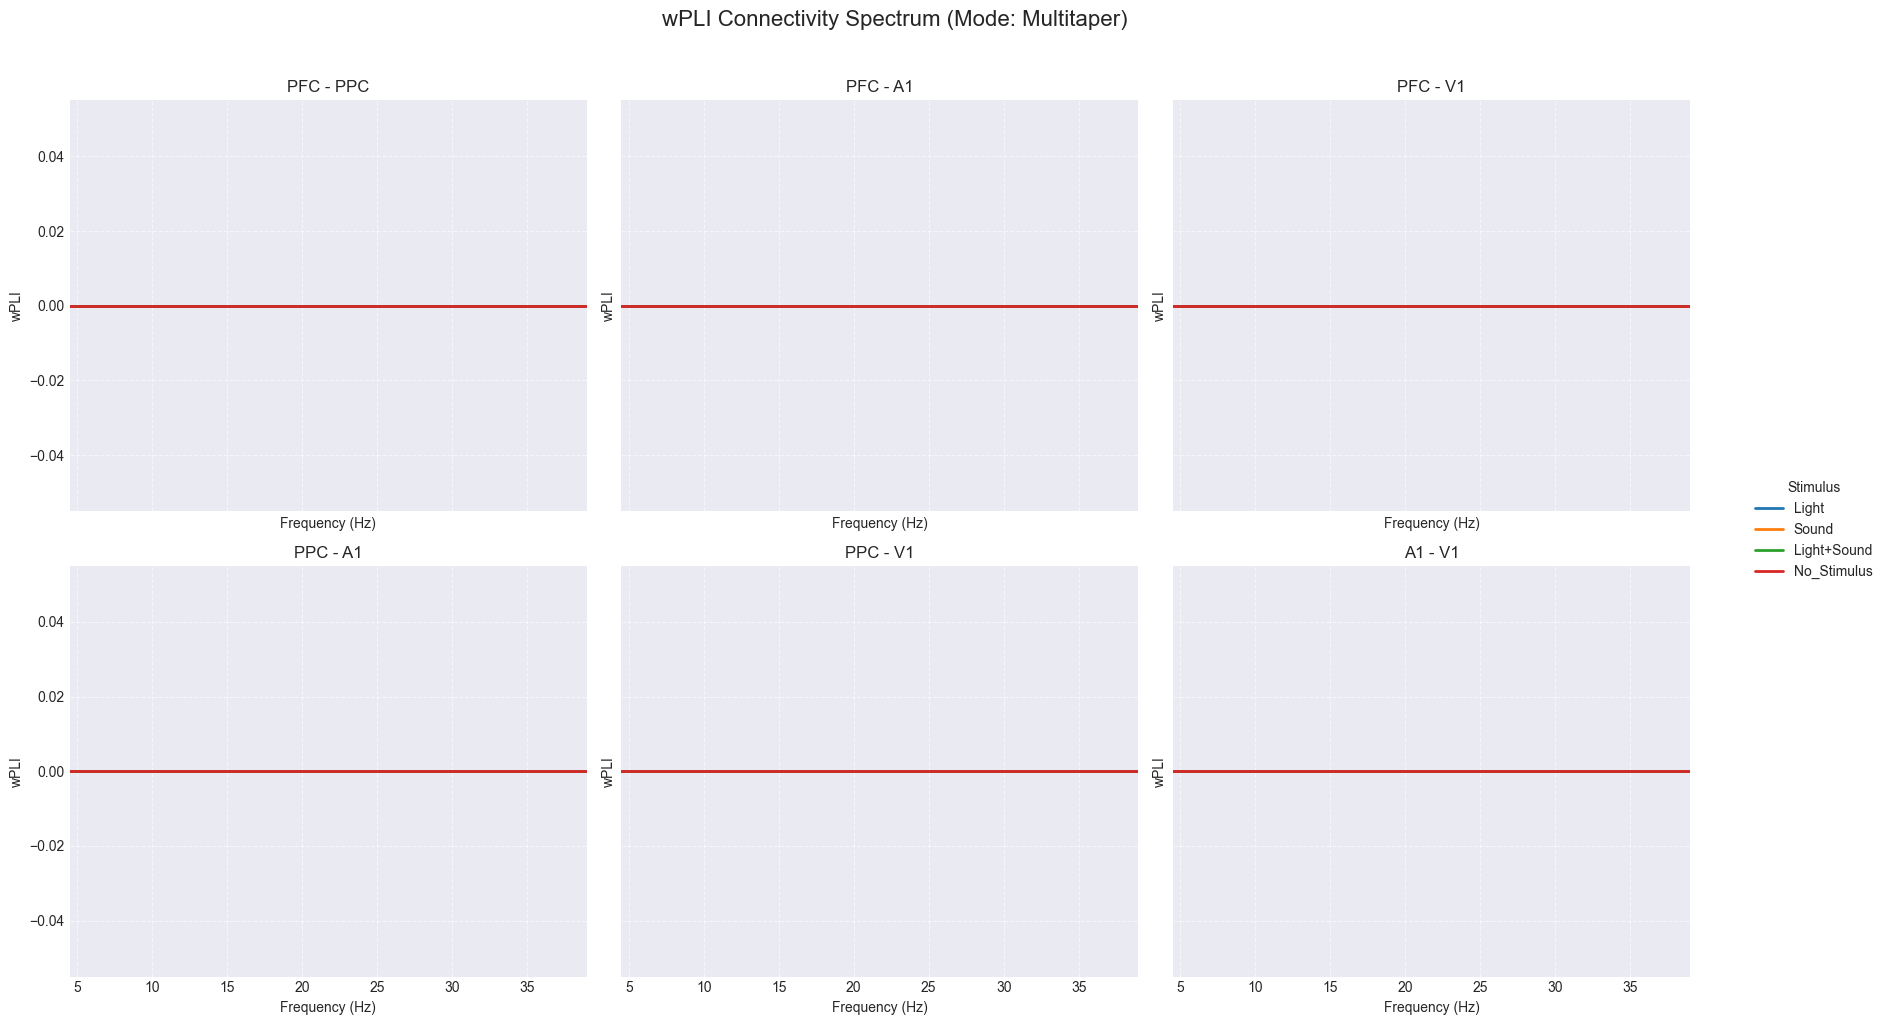

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import itertools # チャンネルペアの組み合わせを生成するために使用

# --- 前提 ---
# 以下の変数が「一番最初」の $wPLI計算コード (mode='multitaper') の
# 実行によって既に存在すると仮定します
# wpli_results: dict
#   キーが刺激条件名, 値が 'multitaper' で計算された SpectralConnectivity
#
# 以下の変数が $エポック化コード の実行によって既に存在すると仮定します
# channels: list
#   チャンネル名のリスト (例: ['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered'])

# --- ここからがプロット用コード ---

# 1. チャンネル名とペアの準備
# ---------------------------------
if 'channels' not in locals() and 'wpli_results' in locals():
    try:
        first_key = next(iter(wpli_results))
        channels = wpli_results[first_key].names
        print("Channels list loaded from wpli_results.names")
    except Exception as e:
        print(f"Error loading channels: {e}")
        # channels = ['PFC_filtered', 'PPC_filtered', 'A1_filtered', 'V1_filtered']

ch_indices = {ch_name: idx for idx, ch_name in enumerate(channels)}
unique_pairs_indices = list(itertools.combinations(range(len(channels)), 2))
unique_pairs_names = [
    (channels[i], channels[j]) for i, j in unique_pairs_indices
]
print(f"Plotting for {len(unique_pairs_indices)} channel pairs.")


# 2. スペクトラムのプロット
# ---------------------------------
# ★ 元の 'multitaper' の wpli_results を使用します
wpli_results_to_plot = wpli_results
stim_conditions = list(wpli_results_to_plot.keys())

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes_flat = axes.flatten()

# 周波数軸を取得 (multitaper計算時の .freqs を使用)
try:
    freqs_raw = wpli_results_to_plot[stim_conditions[0]].freqs
    freqs = np.asarray(freqs_raw)
    
    if freqs.size == 0:
        print("Error: Frequency axis is empty.")
    else:
        print(f"Frequency axis loaded (Type: {type(freqs)}, Min: {freqs.min()}, Max: {freqs.max()})")
except Exception as e:
    print(f"Error accessing frequencies: {e}")
    # $エポック化コード の定義をフォールバックとして使用
    freqs = np.arange(4., 40., 1.0) 
    print(f"Warning: Using fallback frequency definition (4-39 Hz).")


# 各チャンネルペア（サブプロット）でループ
for pair_idx, (idx1, idx2) in enumerate(unique_pairs_indices):
    ax = axes_flat[pair_idx]
    pair_name = f"{channels[idx1].replace('_filtered','')} - {channels[idx2].replace('_filtered','')}"

    # 各刺激条件（プロット内の各線）でループ
    for stim in stim_conditions:
        con = wpli_results_to_plot[stim]
        
        # wpli_matrix_full = con.get_data('dense') に相当
        wpli_data_array = con.get_data(output='dense')
        
        # ご指摘の通り、ヒートマップコードが .mean(axis=2) していたのに対し、
        # ここでは周波数軸(axis=2)をそのままスライスしてデータ (wpli_spectrum) を取得します
        wpli_spectrum = wpli_data_array[idx1, idx2, :]
        
        # freqs と wpli_spectrum の長さが一致するか確認
        if len(freqs) == len(wpli_spectrum):
            ax.plot(freqs, wpli_spectrum, label=stim, linewidth=2)
        else:
            print(f"Warning: Mismatch in lengths for {stim} {pair_name}. Freqs: {len(freqs)}, Data: {len(wpli_spectrum)}")

    ax.set_title(pair_name)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('wPLI')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    if freqs.size > 0:
        ax.set_xlim(freqs.min(), freqs.max())
    # ax.set_ylim(0, 0.5) # y軸の範囲を固定したい場合

# 凡例を最後のサブプロットの隣にまとめて表示
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5), title="Stimulus")

fig.suptitle('wPLI Connectivity Spectrum (Mode: Multitaper)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.95, 1]) # 凡例スペースを確保
plt.show()
